In [1]:
using LibPQ, Tables, Plots, HTTP, CSV, DataFrames, Random, StatsBase, FreqTables, SQLite, Base, Dates
using Base: show_supertypes
plotly()


Plots.PlotlyBackend()

In [ ]:
import Pkg; Pkg.add("Date")

In [2]:
conn = LibPQ.Connection("dbname=sharath")
sqlite = SQLite.DB()

SQLite.DB(":memory:")

In [9]:
function getSeries(symbol::String)
    sql = """select date, adjclose from nse_raw nr where symbol = '"""*symbol*"""' and adjclose is not null order by 1 """
    return columntable(execute(conn, sql))
end

# result = execute(conn, """select "NDP_Date" , "NDP_Close" from ace_equity_nifty_50 aen where "Company Name" = 'Infosys Ltd.' order by 1""")
# result = execute(conn, """select "NDP_Date" , "NDP_Close" from ace_equity_nifty_50 aen where "Company Name" = 'Adani Ports and Special Economic Zone Ltd.' order by 1""")
# result = execute(conn, """select date, adjclose from nse_raw nr where symbol = 'AMBUJACEM' and adjclose is not null order by 1 """)
data = getSeries("INFY")
series = copy(data[2])
# plot((data[1]), copy(data[2]))

5993-element Array{Union{Missing, Float64},1}:
  -0.000432
  -0.000431
  -0.000433
  -0.000431
  -0.000426
  -0.000428
  -0.000423
  -0.00042
  -0.000429
  -0.000427
  -0.000422
  -0.000424
  -0.00042
   ⋮
 589.799988
 606.200012
 643.0
 652.700012
 626.700012
 641.5
 602.799988
 585.700012
 639.0
 631.599976
 636.25
 637.400024

In [10]:
function sip(sipFrequencyDays::Int, sipDurationDays::Int, series)
    n = size(series)[1]
    sipDurationDays = min(sipDurationDays, n)
    rates = Vector{Float64}(undef, n-sipDurationDays+1)
    for i in 1:n-sipDurationDays+1
        stocks::Float64 = 0.0
        innerRange = i:sipFrequencyDays:i+sipDurationDays-1
        for j in innerRange
            
            stocks = stocks + 1/series[j]
        end
        rates[i] = r(lastindex(innerRange), series[last(innerRange)]*stocks, sipDurationDays/365.0)
    end
    return rates
end
# println(typeof(returns[1, :]))
function gogo(series)
    years = 1:6
    returns = Array{Float64}(undef, 101, length(years))

    for year in years
        returns[:, year] = nquantile(sip(1, (year+1)*365, series), 100).*100
    end
    return plot(x, returns, label = permutedims(["year"*string(x+1) for x in years])) 
end
# sip(1, 2*365, series)
plotData = gogo(series)
# print(length(data[2]))
# print(1/data.NDP_Close[3])
# innerRange = 1:3:45
# collect(last(innerRange))

LoadError: DomainError with -1.9843204762122886:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

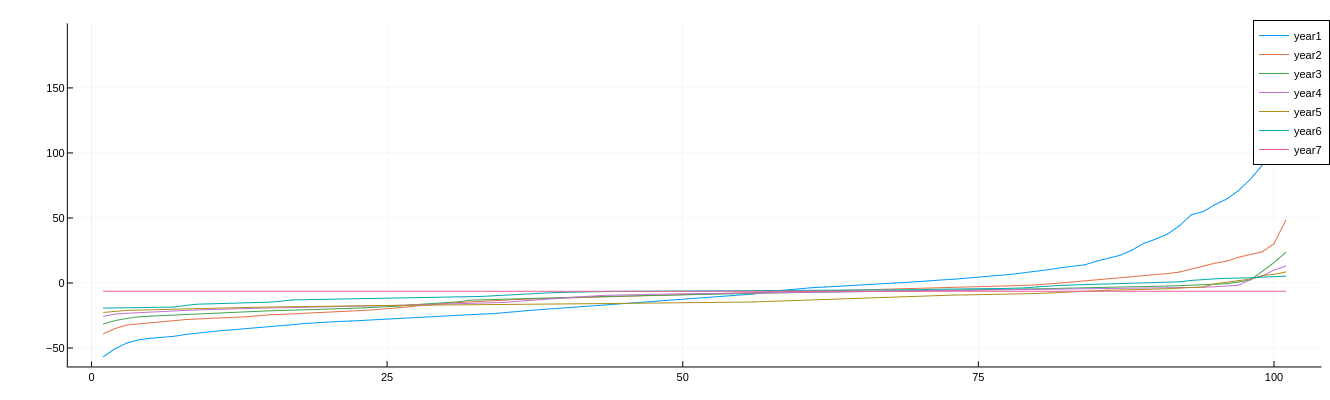

In [58]:
#v2 a linear time algorithm for calculating sip returns. returns an array of returns.
# each element corresponds to a period of sipDurationDays
function sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    series2 = Array{Float64}(undef, 0)
    stocksNow = 0.0
    for i in 1:sipFrequencyDays:length(series)
        append!(series2, series[i])
    end
    n = size(series2)[1]
    rates = Vector{Float64}(undef, 0)
    stocks::Float64 = 0.0
    sipDurationDays = min(n, convert(Int64, floor(sipDurationDays/sipFrequencyDays)))

    
    for i in 1:sipDurationDays
        stocks+=1/series2[i]
    end
    append!(rates, r(sipDurationDays, series[sipDurationDays]*stocks, sipDurationDays/365.0))

    for i in 2:n-sipDurationDays+1
        stocks -= 1/series[i-1]
        stocks += 1/series[i+sipDurationDays-1]
        rate = r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0)
        append!(rates, r(sipDurationDays, series[i+sipDurationDays-1]*stocks, sipDurationDays/365.0))
    end
    return rates
end
# println(typeof(returns[1, :]))
function gogo(symbol)
    years = 1:7
    returns = Array{Float64}(undef, 101, length(years))

    for year in years
        returns[:, year] = nquantile(sipv2(1, (year)*365, d[symbol].prices), 100).*100
    end
    return plot(collect(1:101), returns, label = permutedims(["year"*string(x) for x in years])) 
end
# plot(nquantile(sipv2(1, 3*365, d["INFY"].prices).*100, 100))
plotData = gogo("ORISSAMINE")
# print(length(data[2]))
# print(1/data.NDP_Close[3])
# innerRange = 1:3:45
# collect(last(innerRange))

In [ ]:
struct Point
    dates::Array{DateTime}
    prices::Array{Float64}
end
function constructDict()
    data = columntable(execute(conn, """ select symbol, date, adjclose from work.prices where date is not null and adjclose is not null order by 1, 2"""))
    symbols = copy(data[1])
    dates = copy(data[2])
    adjclose = copy(data[3])
    d = Dict{String, Point}()
    for i in 1:length(symbols)
        symbol = symbols[i]
        date = dates[i]
        price = adjclose[i]
        if !haskey(d, symbol)
            d[symbol] = Point(Array{DateTime}(undef, 0), Array{Float64}(undef, 0))
        end
        point = d[symbol]
        push!(point.dates, dates[i])
        push!(point.prices, adjclose[i])
    end
    return d
end
d = constructDict()

In [ ]:
# returns the probability that the sip makes a return of targetRate considering every possible period whose duration is sipDurationDays
function prob(d::Dict{String, Point}, company::String, sipFrequencyDays::Int, sipDurationDays::Int, targetRate::Float64=0.1)
    series = d[company].prices
    returns = sipv2(sipFrequencyDays::Int, sipDurationDays::Int, series)
    sorted = sort(returns)
    bottom = length(returns)
    top = min(bottom, first(searchsorted(sorted, targetRate)))
    return (bottom-top)/bottom
end

function doplot(d::Dict{String, Point})
    k = collect(keys(d))
    tuples = [(i, prob(d, i, 1, 3*365, 0.1)) for i in k]
    filter(x->x[2]>0.7,sort!( tuples, by=last))
    
#     return plot(getindex.(tuples,1), getindex.(tuples, 2))
end
println(doplot(d))
# (filter(x->x[2]<0 , collect(zip(1:length(d["INFY"]), [p.price for p in d["INFY"]]))))
# zip(1:length(d["INFY"]), [p.price for p in d["INFY"]])
# filter(p -> p[1]<0, )
# prob(d, "UJJIVANSFB", 1, 100, 0.1)
# [p.price for p in (d["INFY"][:4])]
# println(([p.price for p in d["INFY"][2000:2010]]))

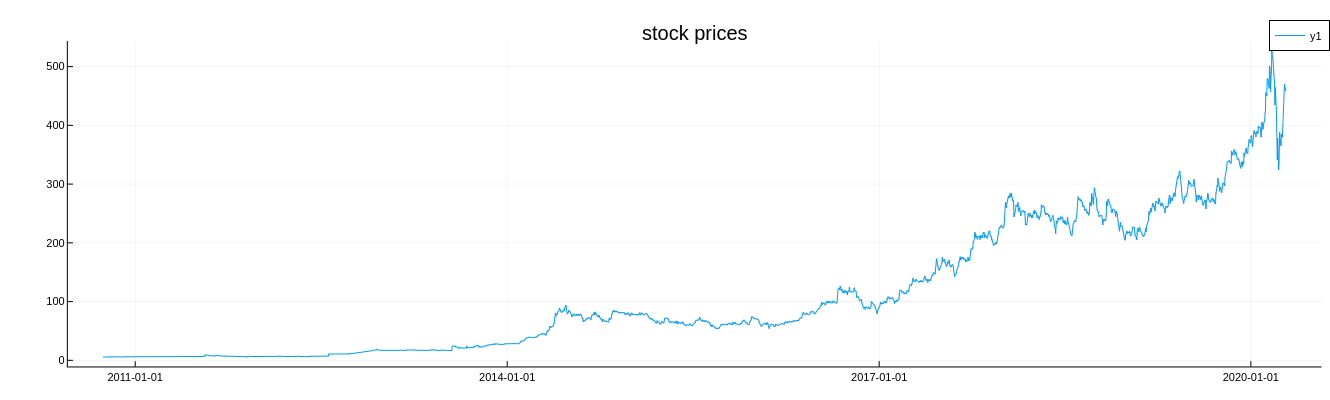

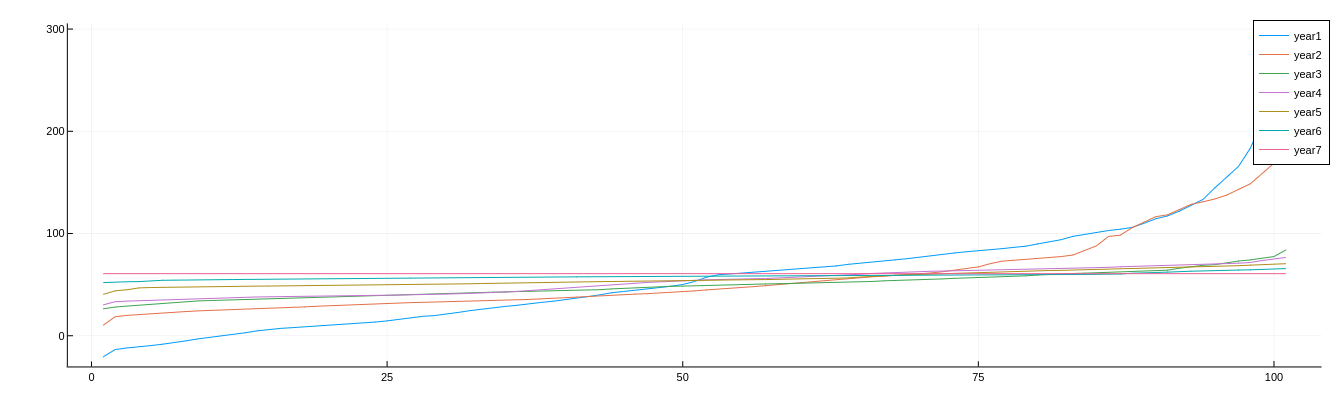

In [81]:
function stock(symbol::String)
    display(plot(d[symbol].dates, d[symbol].prices, title="stock prices"))
    display(gogo(symbol))
end
stock("DEEPAKNTR")

In [ ]:
show_supertypes(typeof(data.NDP_Date))

In [ ]:
function ohlc2()
    function get_ohlc(ticker; kwargs...)
        res = HTTP.get("https://www.quandl.com/api/v3/datasets/WIKI/$(ticker)/data.csv?start_date=2017-01-01")
        df = CSV.read(res.body)
        ohlc(df, x=:Date, open=:Open, high=:High, low=:Low, close=:Close; kwargs...)
    end

    p1 = plot(get_ohlc("AAPL", name="Apple"), Layout(title="Apple"))
    p2 = plot(get_ohlc("GOOG", name="Google"), Layout(title="Google"))

    [p1 p2]
end
ohlc2()

In [ ]:
death = 100
age = 37
months = (death - age)*12
inflationPerMonth = 6/(100*12)
monthlyCost = 100000
living = monthlyCost * months
println(living)
marriage = 1000000
# education is 100000 per year (present value) starting from 5th year to 5+16 years

education = 16*100000
total = living + marriage + 2*education
println(total)

In [6]:
struct Foo
    a::Int64
    b::Int64
end
function ff()
    x::Array{Foo} = [Foo(1)]
    println(x)
end
ff()

LoadError: invalid redefinition of constant Foo

In [6]:
function p2(p1::Number, r::Number, t::Number)
    return Float64(p1)*((1+Float64(r))^Float64(t))
end

function t(p1::Number, p2::Number, r::Number)
    return log(Float64(p2)/Float64(p1)) / log(1+Float64(r))
end

function p1(p2::Number, r::Number, t::Number)
    return Float64(p2)/((1+Float64(r))^Float64(t))
end

function r(p1::Number, p2::Number, t::Number)
    power = log(Float64(p2)/Float64(p1))/Float64(t)
    return exp(power) - 1
end

function emi(p1::Number, r::Number, t::Number)
    x::Float64 = (1.0 + Float64(r))^Float64(t)
    return Float64(p1) * Float64(r) * x / (x - 1)
end


emi (generic function with 1 method)

In [ ]:
df = CSV.read("/home/sharath/Downloads/AdultDataSet.csv")

In [ ]:
df2 = df[shuffle(1:nrow(df))[1:Int(floor((nrow(df)/5)))], :]

In [ ]:
function two_hists(df, df2)
    trace1 = histogram(x=df["age"], opacity=0.75)
    trace2 = histogram(x=df2["age"], opacity=0.75)
    data = [trace1, trace2]
    layout = Layout(barmode="overlay")
    plot(data, layout)
end
two_hists(df, df2)

In [ ]:
plot([histogram(x=randn(10000), opacity=0.75)], Layout(barmode="overlay"))



In [ ]:
filter(row->row["education"]==" HS-grad" && row["marital-status"]==" Never-married", df)

In [ ]:
typeof(freqtable(df["education"], df["marital-status"]))

In [ ]:
df |> SQLite.load!(sqlite, "adult")

In [ ]:
df = DBInterface.execute(sqlite, "select * from adult") |> DataFrame